Import Libraries

In [78]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import os

# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 2 # let's look at sample match 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Metrics

In [79]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [81]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

Reading team: home
Reading team: away


Merge the two tracking DataFrames based on the 'Time [s]' column, which is common to both

In [120]:
tracking_data = pd.merge(tracking_away, tracking_home, on='Time [s]', how='outer')

# Sort the combined DataFrame by the 'Time [s]' column
tracking_data = tracking_data.sort_values(by='Time [s]')

# Reset the index of the combined DataFrame
tracking_data.reset_index(drop=True, inplace=True)

# fill NaN values with 0:
tracking_data.fillna(0, inplace=True)
tracking_data.drop(['ball_x_x', 'ball_y_x', 'Period_y'], axis=1, inplace=True)
tracking_data.rename(columns={'ball_x_y': 'ball_x', 'ball_y_y': 'ball_y', 'Period_x': 'Period'}, inplace=True)
tracking_data
tracking_data.to_csv('tracking_data.csv', index=False)

In [83]:
# dimensions of the field: 105x68 meters.

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2))]
home_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [84]:
home_moments.shape

(120, 56)

In [85]:
home_moments.columns.get_loc('Home_11_x')

26

Find Home Team High Pressure moment #1

In [86]:
import numpy as np

a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

# Loop through each row and calculate the distance for each player
for index, row in home_moments.iterrows():
    distances_away = []
    distances_home = []
    ball_x = row['ball_x']
    ball_y = row['ball_y']

    for a_player in a_players:
        # Get the index of the current player column
        a_index = row.index.get_loc(a_player)
        away_x = row.iloc[a_index]
        away_y = row.iloc[a_index + 1]

        # Calculate Euclidean distance
        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)
        distances_away.append(distance_away)

    for h_player in h_players:
        # Get the index of the current player column
        h_index = row.index.get_loc(h_player)
        home_x = row.iloc[h_index]
        home_y = row.iloc[h_index + 1]

        # Calculate Euclidean distance
        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)
        distances_home.append(distance_home)
    
    away_min_dist = np.min(distances_away)
    home_min_dist = np.min(distance_home)
    # Find the minimum distance for the current row
    if home_min_dist < away_min_dist :
        home_moments.drop(index, inplace=True)

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [87]:
home_moments.shape

(117, 56)

In [88]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


Find the exact event before the high pressure moment happen

In [89]:
moments_event = pd.DataFrame(columns=events.columns)

for index, row in home_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                moments_event = moments_event.append(events.iloc[e_index - 1], ignore_index=True)

moments_event
moments_event.to_csv('moments_event.csv', index=False)


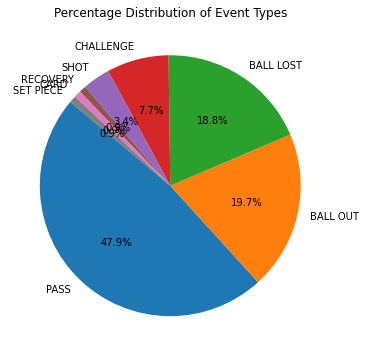

In [106]:
# Pie Chart for percentage distribution of event types
event_type_counts = moments_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [93]:
# Imputing missing values with 'Unknown'
moments_event['Subtype'].fillna('Unknown', inplace=True)
moments_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = moments_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

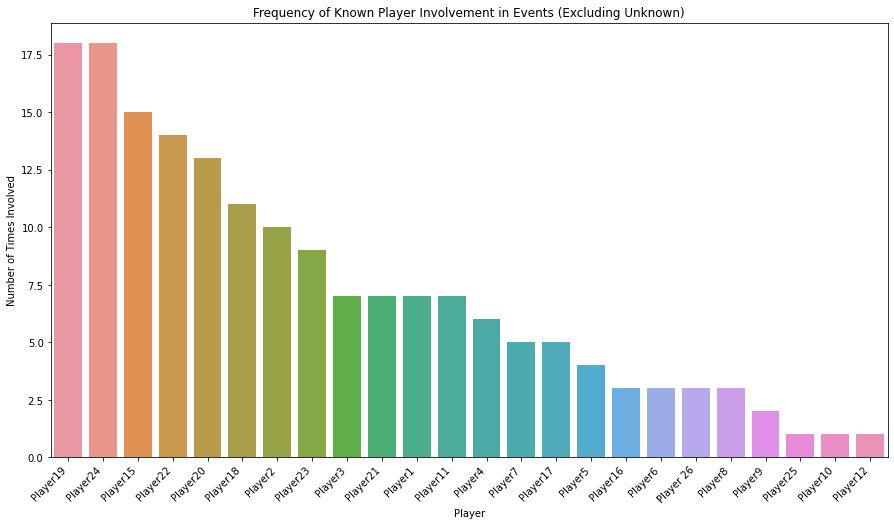

In [113]:
import seaborn as sns

combined_players = moments_event['From'].append(moments_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Excluding 'Unknown' from the player counts
player_counts_excluding_unknown = player_counts.drop('Unknown')

# Creating a DataFrame for the updated player counts
player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [109]:
from sklearn.preprocessing import OneHotEncoder

# Selecting the relevant columns for clustering
features = moments_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CARD,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-LOST,Subtype_CLEARANCE,Subtype_CROSS,Subtype_GROUND,Subtype_GROUND-FAULT-LOST,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HEAD,Subtype_HEAD-CLEARANCE,Subtype_HEAD-INTERCEPTION,Subtype_INTERCEPTION,Subtype_OFF TARGET-HEAD-OUT,Subtype_OFF TARGET-OUT,Subtype_TACKLE-LOST,Subtype_THROW IN,Subtype_Unknown,Subtype_YELLOW,From_Player 26,From_Player1,From_Player10,From_Player11,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player 26,To_Player1,To_Player11,To_Player12,To_Player15,To_Player18,To_Player19,To_Player2,To_Player20,To_Player22,To_Player23,To_Player24,To_Player3,To_Player7,To_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [115]:
# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
moments_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
moments_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster_3,Cluster_4,Cluster
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,2,2,3
1,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,2,2,3
2,Home,PASS,Unknown,1,2511,100.44,2546,101.84,Player4,Player3,0.61,0.97,0.76,0.87,1,0,2
3,Home,PASS,Unknown,1,3248,129.92,3311,132.44,Player3,Player11,0.58,0.27,0.86,0.45,1,0,2
4,Away,PASS,Unknown,1,14189,567.56,14234,569.36,Player15,Player19,0.62,0.99,0.75,0.86,1,0,4


##### Analysis of clusters

In [117]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = moments_event[moments_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,CHALLENGE 9 SHOT 4 CARD 1 N...,Player1 2 Player23 2 Player18 2 Name...,"Unknown 15 Name: To, dtype: int64"
1,BALL OUT 23 BALL LOST 5 RECOVERY ...,Player17 4 Player22 4 Player5 3 Name...,"Unknown 29 Name: To, dtype: int64"
2,"PASS 46 Name: Type, dtype: int64",Player15 5 Player20 5 Player4 4 Name...,Player24 10 Player11 6 Player2 6 N...
3,"BALL LOST 17 Name: Type, dtype: int64",Player24 4 Player20 2 Player19 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"PASS 10 Name: Type, dtype: int64",Player15 4 Player22 2 Player21 2 Name...,"Player19 10 Name: To, dtype: int64"


##### Visualize clusters

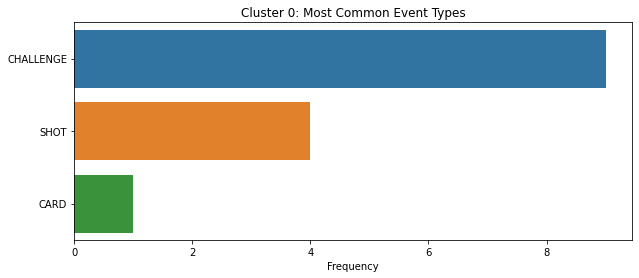

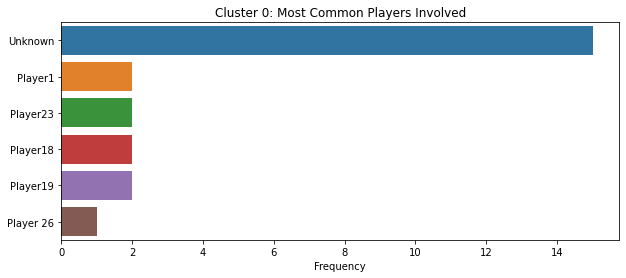

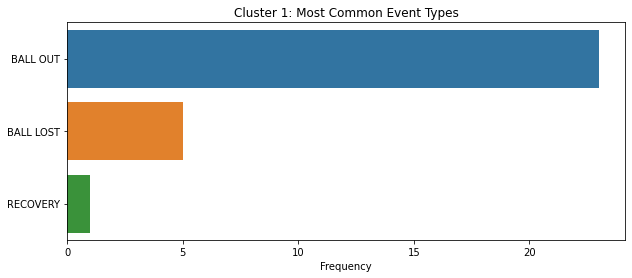

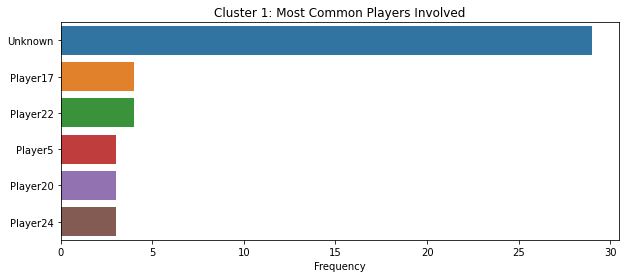

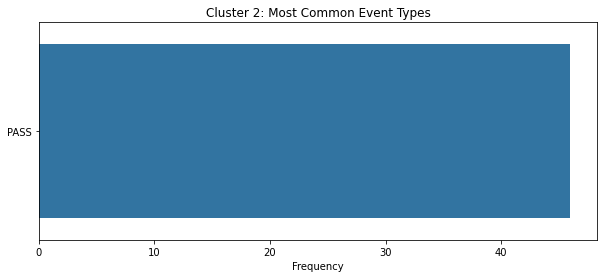

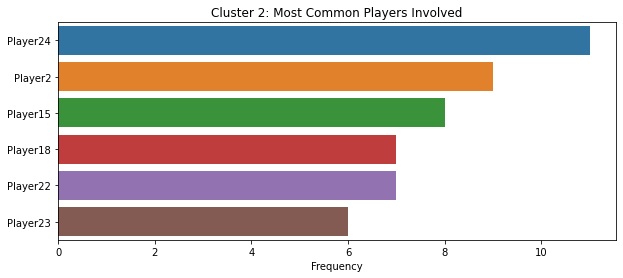

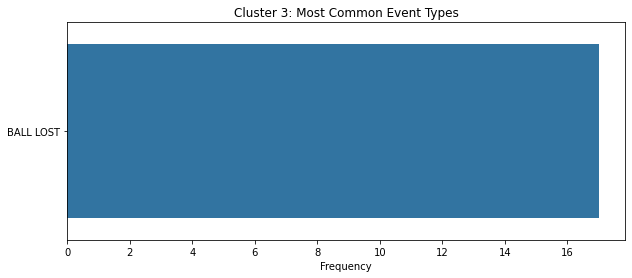

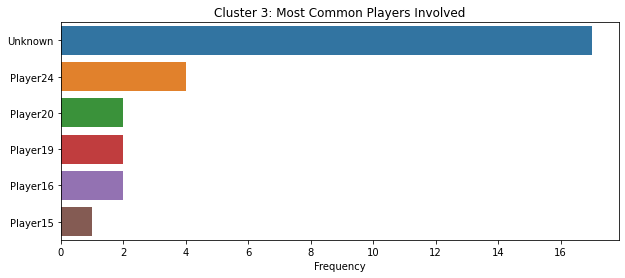

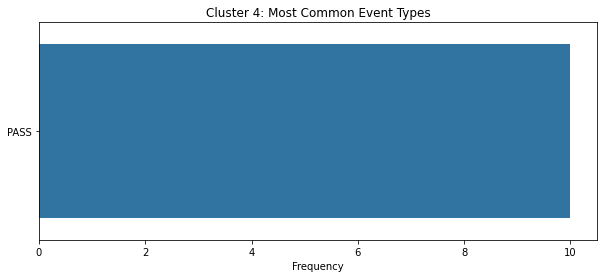

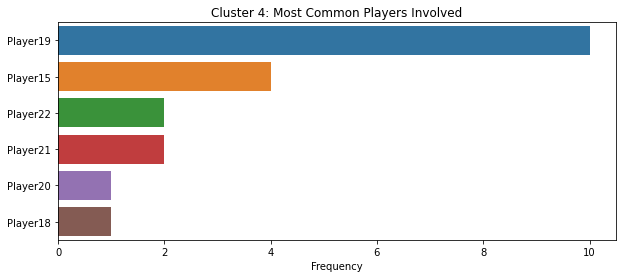

In [119]:
import seaborn as sns

def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = moments_event[moments_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [136]:
away_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1))]
away_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

Find the exact e

In [138]:
away_event = pd.DataFrame(columns=events.columns)

for index, row in away_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                away_event = away_event.append(events.iloc[e_index - 1], ignore_index=True)

away_event
away_event.to_csv('away_event.csv', index=False)

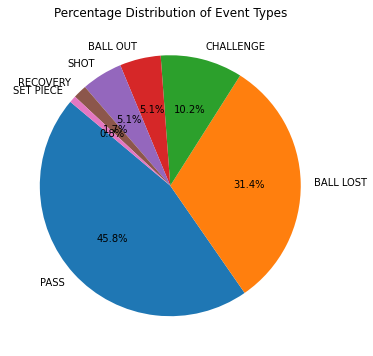

In [141]:
# Pie Chart for percentage distribution of event types
event_type_counts = away_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

In [142]:
# Imputing missing values with 'Unknown'
away_event['Subtype'].fillna('Unknown', inplace=True)
away_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = away_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

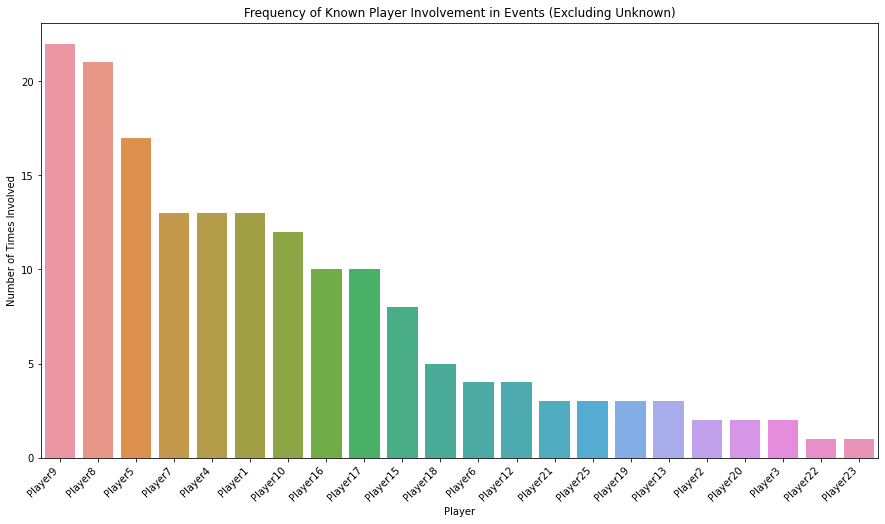

In [143]:
combined_players = away_event['From'].append(away_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Excluding 'Unknown' from the player counts
player_counts_excluding_unknown = player_counts.drop('Unknown')

# Creating a DataFrame for the updated player counts
player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events for Team Away')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

#### SEPRATING PERIODS For Home

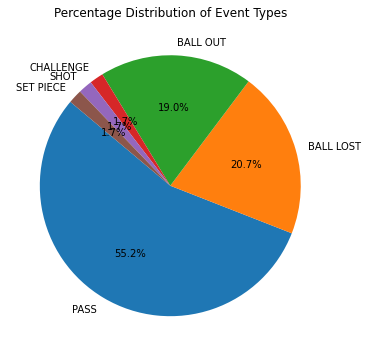

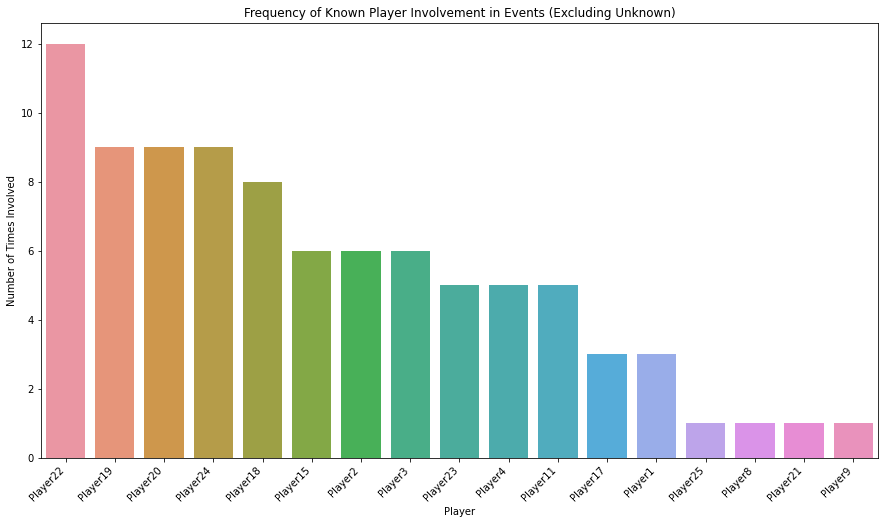

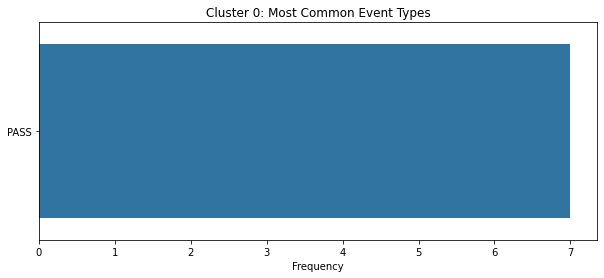

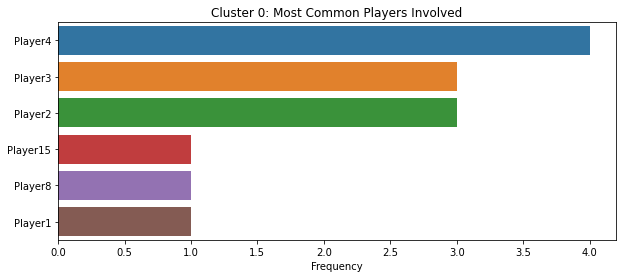

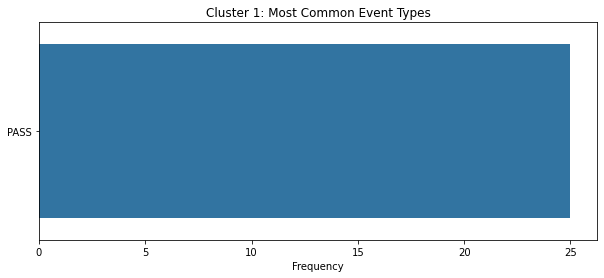

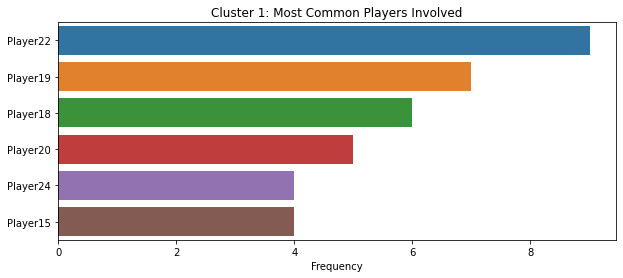

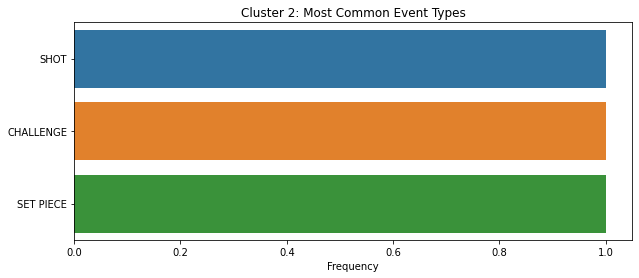

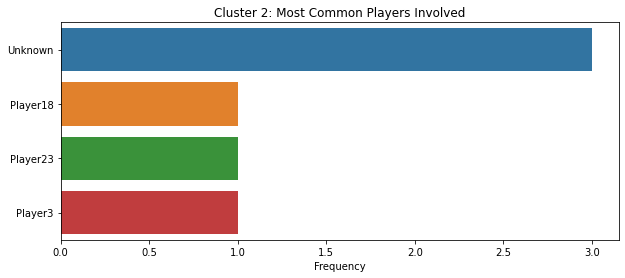

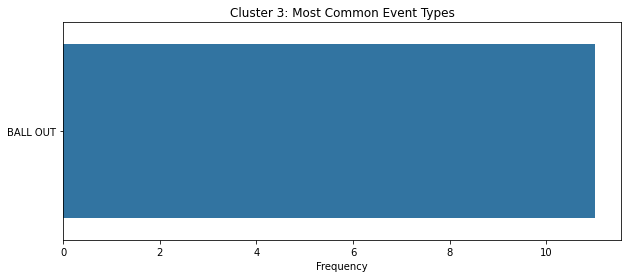

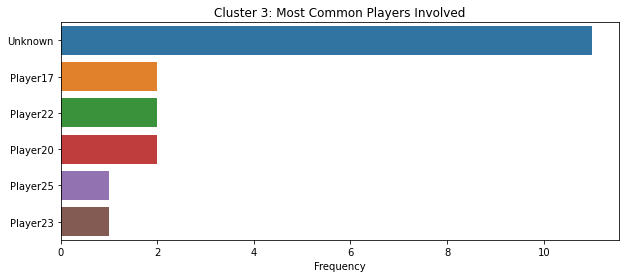

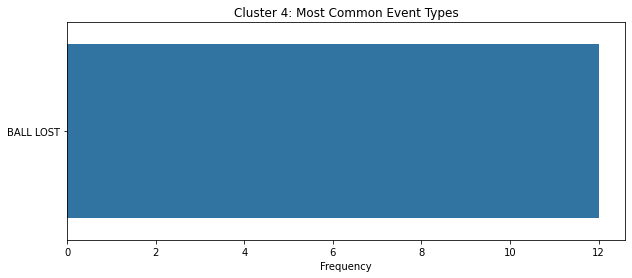

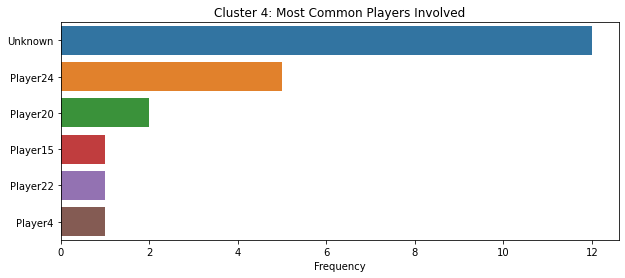

In [121]:

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1))]

home_moments.columns


import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


moments_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 moments_event = moments_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = moments_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


moments_event['Subtype'].fillna('Unknown', inplace=True)

moments_event['To'].fillna('Unknown', inplace=True)

imputation_check = moments_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = moments_event['From'].append(moments_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = moments_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

moments_event['Cluster'] = clusters

moments_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = moments_event[moments_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = moments_event[moments_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


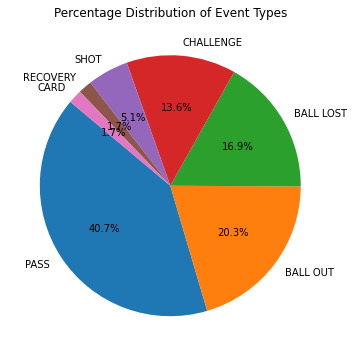

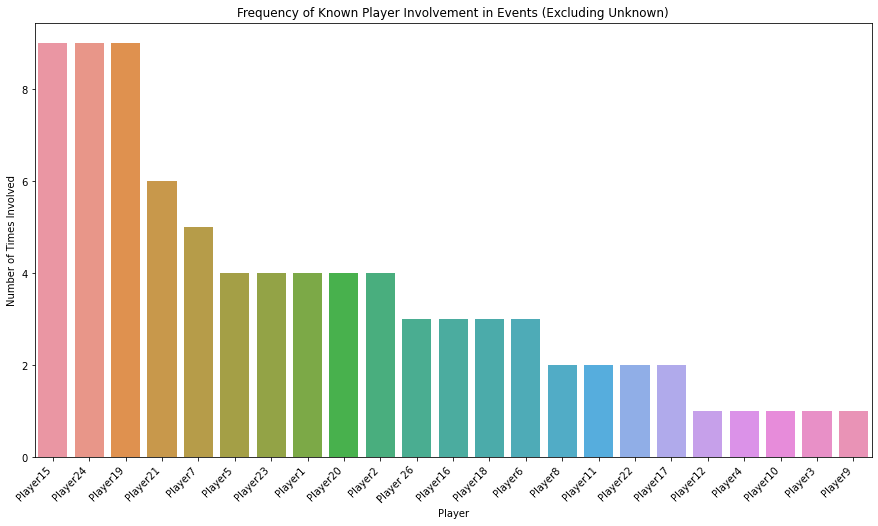

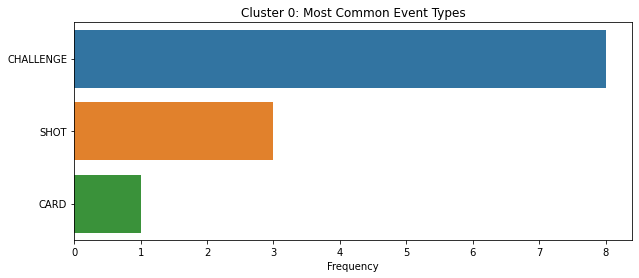

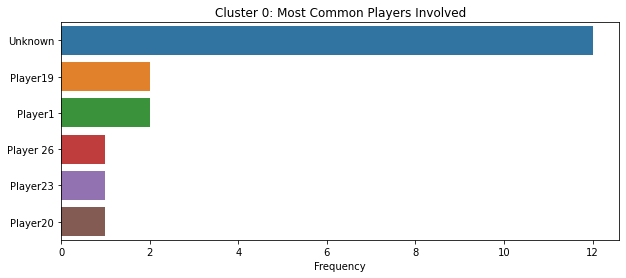

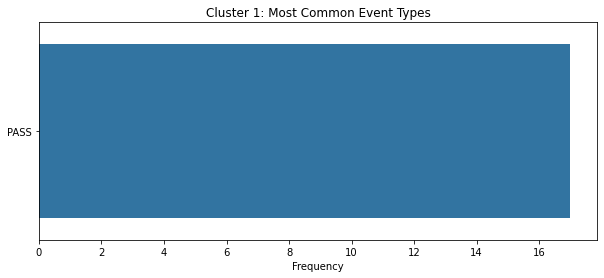

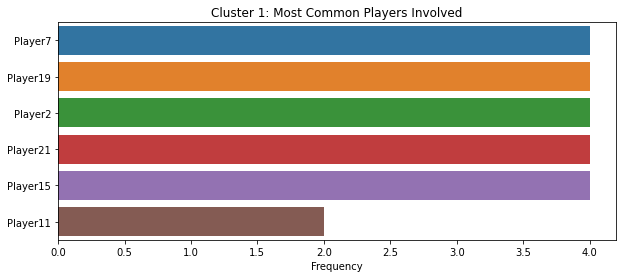

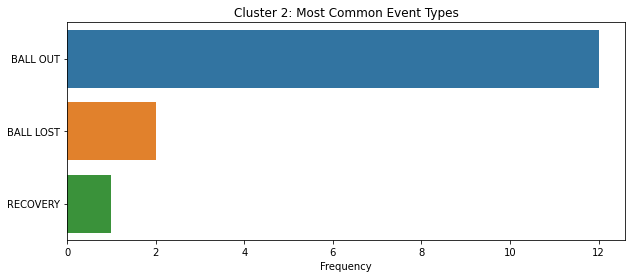

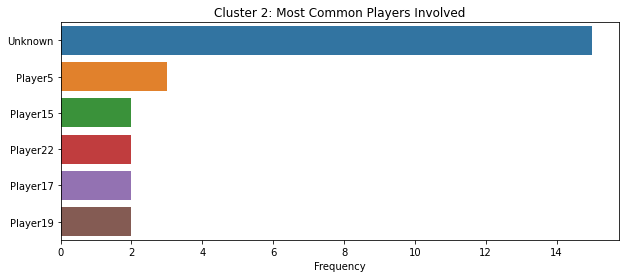

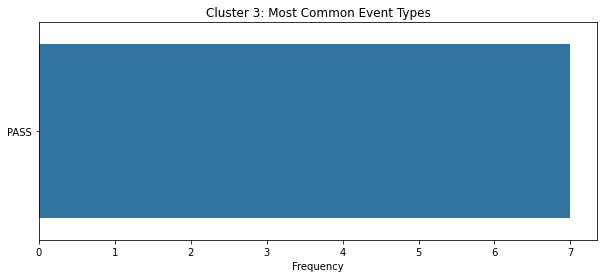

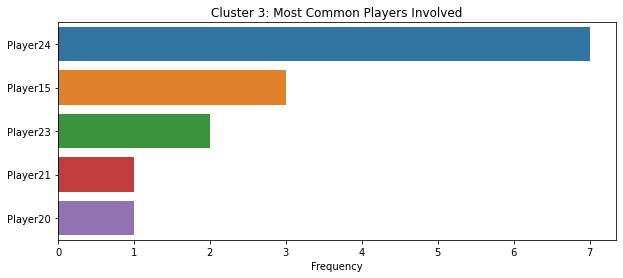

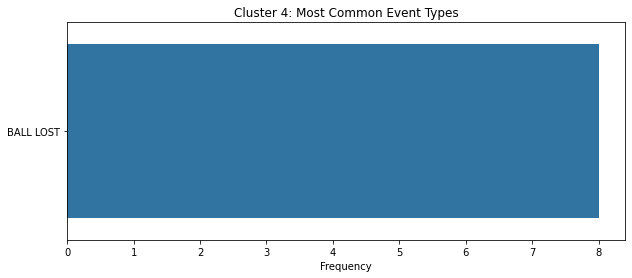

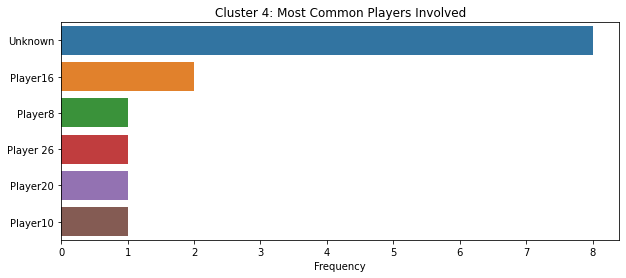

In [123]:

home_moments = tracking_data[(tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2)]
home_moments.columns

import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


moments_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 moments_event = moments_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = moments_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


moments_event['Subtype'].fillna('Unknown', inplace=True)

moments_event['To'].fillna('Unknown', inplace=True)

imputation_check = moments_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = moments_event['From'].append(moments_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = moments_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

moments_event['Cluster'] = clusters

moments_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = moments_event[moments_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = moments_event[moments_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')